### Notebook to plot the scaling of the EP bound for hot, intermediate, and cold systems

In [12]:
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
import itertools
import scipy

## Define global params
J = 1.
M = 1.
beta = 0.4
# n_array = np.logspace(2,5,num=4,base=2.)
n_array = np.linspace(6,18,7)
# n_array = np.linspace(4,32,8)
# init = 'uni' ## initial distribution ('uni','delta','random')
# init = 'delta' ## initial distribution ('uni','delta','random')
init = 'random' ## initial distribution ('uni','delta','random')

## Define a function to calculate the hamiltonian for a given spin config
def get_H(spin_config):
    length = len(spin_config)
    
    H_tot = 0.
    for i in range(length-1):
        H_i = 0.
        if i%2 == 0:
            H_i = -M*spin_config[i]
        else:
            H_i = -J*(spin_config[i]*spin_config[i-1]+spin_config[i]*spin_config[i+1])-M*spin_config[i]
        H_tot = H_tot + H_i    
        
    ### Calculate contribution from PBC
    H_i = 0
    if length%2 == 0:
        H_i = -J*(spin_config[-1]*spin_config[-2]+spin_config[-1]*spin_config[0])-M*spin_config[-1]
    else:
        H_i = -M*spin_config[-1]
    H_tot = H_tot + H_i

    return(H_tot)

## Define a function to return all spin configs of size n
def all_configs(n):
    final_array = []
    for i in itertools.product('01', repeat=n):
        empty_list = []
        for each in i:
            if each == '0':
                empty_list.append(-1)
            else:
                empty_list.append(1)
        final_array.append(empty_list)
    return(final_array)

## Define Function to calculate entropy
def get_S(dist):
    S = 0
    for p_i in dist:
        if p_i != 0.:
            S = S - p_i*np.log2(p_i)
    return(S)

## Define Function to get the units in our autonomous spin model
def get_units(n):
    if n%2 != 0:
        print("ERROR - n must be even!")
        return(-1)
    else: 
        units = []
        for i in range(n-1):
            if i%2 == 0:
                units.append([i])
            else:
                units.append([i-1,i,i+1])
        units.append([n-2,n-1,0])
        return(units)

## Define Function to calculate in-ex sum for a given dependency struct
def I_Nstar(p_array,units):
    prob_dist = p_array
#     print("\nPROB DIST = ",prob_dist)
    n_units = len(units)
    
    ## First get entropy of global system
    S_tot = -1*get_S(prob_dist)
#     print("Global Entropy Contribution = ",S_tot)
    
    ## Now get entropy of units
    for unit in units:
        if len(unit) == 1:
            sign = -1.
        elif len(unit) == 3:
            sign = 1.
        else:
            print("ERROR - UNIT NOT A NODE OR LEAF")
            break
            
        configurations = all_configs(len(unit))  # gets possible values for intersection
        p_dist = []   # empty list to hold the probabilities over the different configurations
                
        ## Calculate entropy of marginal distribution
        for spin_config in configurations:
            index_list = []
            
            ## get index where original array matches spin_config
            for m in range(len(unit)):
                subsystem = unit[m]  # get the index of each spin
                index_list.append(spin_df.index[spin_df[subsystem]==spin_config[m]].tolist())
            final_indices = list(set(index_list[0]).intersection(*index_list))
            p_dist.append(np.sum(np.asarray(prob_dist)[final_indices]))
#         print("\t\tMarginal Dist = ",p_dist)
#         print("\t\tEntropy Contribution = ",sign*get_S(p_dist))
        S_tot = S_tot + sign*get_S(p_dist)  # sum entropy contribution from unit
        
    return(S_tot)


EP_bounds = []
for n in n_array:
    n = int(n)
    print("N = ",n)
    print("units = ",get_units(n))
    
    ## Get initial distribution (uniform)
    if init == 'uni':
        p_init = np.ones(np.power(2,n))
        p_init = p_init/np.sum(p_init)
    elif init == 'delta':
        p_init = np.zeros(np.power(2,n))
        p_init[0] = 1.
    elif init == 'random':
        p_init = np.random.rand(np.power(2,n))
        p_init = p_init/np.sum(p_init)
    else:
        print("ERROR - Initial dist not specified!")
        break
        
    ## Calculate final distribution (Boltzamnn Dist)
    spin_configs = all_configs(n)
    spin_df = pd.DataFrame(spin_configs)
    pi_vector = []
    for config in spin_configs:
        H = get_H(config)
        pi_vector.append(np.exp(-beta*H))
    pi_vector = pi_vector/np.sum(pi_vector) ## normalize
    
    ## Get I_Nstar(initial)
    I_t0 = I_Nstar(p_init,get_units(n))
    I_tf = I_Nstar(pi_vector,get_units(n))
    print("I_star(t_0) = ", I_t0)
    print("I_star(t_f) = ", I_tf)
    print("\n")
    EP_bounds.append(-(I_tf-I_t0))
    
print("DONE")

N =  6
units =  [[0], [0, 1, 2], [2], [2, 3, 4], [4], [4, 5, 0]]
I_star(t_0) =  0.1604912351975072
I_star(t_f) =  -0.0007860932150003386


N =  8
units =  [[0], [0, 1, 2], [2], [2, 3, 4], [4], [4, 5, 6], [6], [6, 7, 0]]
I_star(t_0) =  0.266353421513549
I_star(t_f) =  -5.45188980374256e-05


N =  10
units =  [[0], [0, 1, 2], [2], [2, 3, 4], [4], [4, 5, 6], [6], [6, 7, 8], [8], [8, 9, 0]]
I_star(t_0) =  0.26843990080418667
I_star(t_f) =  -4.201701761630261e-06


N =  12
units =  [[0], [0, 1, 2], [2], [2, 3, 4], [4], [4, 5, 6], [6], [6, 7, 8], [8], [8, 9, 10], [10], [10, 11, 0]]
I_star(t_0) =  0.2702878873443697
I_star(t_f) =  -3.277705138415854e-07


N =  14
units =  [[0], [0, 1, 2], [2], [2, 3, 4], [4], [4, 5, 6], [6], [6, 7, 8], [8], [8, 9, 10], [10], [10, 11, 12], [12], [12, 13, 0]]
I_star(t_0) =  0.2789504964488847
I_star(t_f) =  -2.5599512287755033e-08


N =  16
units =  [[0], [0, 1, 2], [2], [2, 3, 4], [4], [4, 5, 6], [6], [6, 7, 8], [8], [8, 9, 10], [10], [10, 11, 12], [12], [12, 

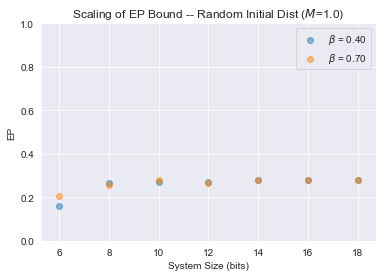

In [13]:
# beta_15 = EP_bounds
# beta_40 = EP_bounds
# beta_70 = EP_bounds

# plt.scatter(n_array,beta_15,alpha=0.5,label=r'$\beta$ = 0.15')
plt.scatter(n_array,beta_40,alpha=0.5,label=r'$\beta$ = 0.40')
plt.scatter(n_array,beta_70,alpha=0.5,label=r'$\beta$ = 0.70')

# plt.scatter(inter_lower_uniform_dict.keys(),inter_lower_uniform_dict.values(),alpha=0.5,label='uniform initial dist')
# plt.scatter(inter_lower_delta_dict.keys(),inter_lower_delta_dict.values(),marker='x',alpha=0.5,label=r'$\delta$ initial dist')
plt.xlabel('System Size (bits)')
plt.ylabel('EP')
plt.title(r'Scaling of EP Bound -- Random Initial Dist ($M$='+str(M)+')')
plt.ylim((0,1))
plt.legend(loc='best')
# plt.savefig('EP_bound_scaling_random_init2.pdf')
plt.show()

### A bunch of random initial distributions will yield a non-zero EP bound ~0.30

In [39]:
#### Save lower bound on EP for a hot system with a uniform initial dist
import pickle

# n_array = [4,6,8,10,12,14,16]
# hot_lower_uniform = [0,0,0,0,0,0,0]
# hot_lower_uniform_dict = dict(zip(n_array, hot_lower_uniform)) 

# hot_lower_delta_dict = dict(zip(n_array,EP_bounds))
# cold_lower_uniform_dict = dict(zip(n_array,EP_bounds))

# inter_lower_uniform_dict = dict(zip(n_array,EP_bounds))
inter_lower_delta_dict = dict(zip(n_array,EP_bounds))


with open('inter_lower_delta.pickle','wb') as handle:
    pickle.dump(inter_lower_delta_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('cold_lower_uniform.pickle','wb') as handle:
#     pickle.dump(cold_lower_uniform_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('cold_lower_delta.pickle','wb') as handle:
#     pickle.dump(cold_lower_delta_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('hot_lower_uniform.pickle','wb') as handle:
#     pickle.dump(hot_lower_uniform_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('hot_lower_delta.pickle','wb') as handle:
#     pickle.dump(hot_lower_delta_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## To reload:
# with open('hot_lower_uniform.pickle', 'rb') as handle:
#     hot_lower_uniform_dict = pickle.load(handle)
    
# ## To reload:
# with open('hot_lower_delta.pickle', 'rb') as handle:
#     hot_lower_delta_dict = pickle.load(handle)
    
    
print("DONE")

DONE


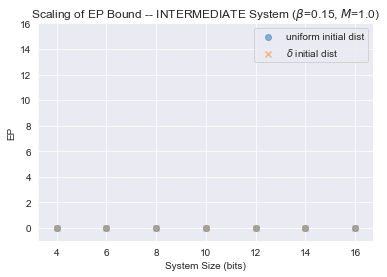

In [6]:
# ## To reload:
# with open('hot_lower_uniform.pickle', 'rb') as handle:
#     hot_lower_uniform_dict = pickle.load(handle)

# with open('cold_lower_uniform.pickle', 'rb') as handle:
#     cold_lower_uniform_dict = pickle.load(handle)
    
# with open('cold_lower_delta.pickle', 'rb') as handle:
#     cold_lower_delta_dict = pickle.load(handle)

with open('inter_lower_uniform.pickle', 'rb') as handle:
    inter_lower_uniform_dict = pickle.load(handle)
    
with open('inter_lower_delta.pickle', 'rb') as handle:
    inter_lower_delta_dict = pickle.load(handle)


plt.scatter(inter_lower_uniform_dict.keys(),inter_lower_uniform_dict.values(),alpha=0.5,label='uniform initial dist')
plt.scatter(inter_lower_delta_dict.keys(),inter_lower_delta_dict.values(),marker='x',alpha=0.5,label=r'$\delta$ initial dist')
plt.xlabel('System Size (bits)')
plt.ylabel('EP')
plt.title(r'Scaling of EP Bound -- INTERMEDIATE System ($\beta$='+str(beta) +', $M$='+str(M)+')')
plt.ylim((-1,16))
plt.legend(loc='best')
plt.savefig('EP_bound_scaling_inter.pdf')
plt.show()

#### Now for a hot system

In [23]:
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
import itertools
import scipy

## Define global params
J = 1.
M = 1.
beta = 1e-6
# n_array = np.logspace(2,5,num=4,base=2.)
n_array = np.linspace(4,16,7)
# init = 'uni' ## initial distribution ('uni','delta')
init = 'delta' ## initial distribution ('uni','delta')
print(n_array)

## Define a function to calculate the hamiltonian for a given spin config
def get_H(spin_config):
    length = len(spin_config)
    
    H_tot = 0.
    for i in range(length-1):
        H_i = 0.
        if i%2 == 0:
            H_i = -M*spin_config[i]
        else:
            H_i = -J*(spin_config[i]*spin_config[i-1]+spin_config[i]*spin_config[i+1])-M*spin_config[i]
        H_tot = H_tot + H_i    
        
    ### Calculate contribution from PBC
    H_i = 0
    if length%2 == 0:
        H_i = -J*(spin_config[-1]*spin_config[-2]+spin_config[-1]*spin_config[0])-M*spin_config[-1]
    else:
        H_i = -M*spin_config[-1]
    H_tot = H_tot + H_i

    return(H_tot)

## Define a function to return all spin configs of size n
def all_configs(n):
    final_array = []
    for i in itertools.product('01', repeat=n):
        empty_list = []
        for each in i:
            if each == '0':
                empty_list.append(-1)
            else:
                empty_list.append(1)
        final_array.append(empty_list)
    return(final_array)

## Define Function to calculate entropy
def get_S(dist):
    S = 0
    for p_i in dist:
        if p_i != 0.:
            S = S - p_i*np.log2(p_i)
    return(S)

## Define Function to get the units in our autonomous spin model
def get_units(n):
    if n%2 != 0:
        print("ERROR - n must be even!")
        return(-1)
    else: 
        units = []
        for i in range(n-1):
            if i%2 == 0:
                units.append([i])
            else:
                units.append([i-1,i,i+1])
        units.append([n-2,n-1,0])
        return(units)

## Define Function to calculate in-ex sum for a given dependency struct
def I_Nstar(p_array,units):
    prob_dist = p_array
#     print("\nPROB DIST = ",prob_dist)
    n_units = len(units)
    
    ## First get entropy of global system
    S_tot = -1*get_S(prob_dist)
    print("Global Entropy Contribution = ",S_tot)
    
    ## Now do in-ex sum over units
    for k in range(1,n_units+1):
        if k % 2 == 0:
            sign = -1.
        else:
            sign = 1.
        print("k-wise intersections with k = ",k)
        ### TO DO - Don't go past 3-way intersections; only look at neighboring units
        for unit_list in itertools.combinations(units, k):
            intersection = list(set(unit_list[0]).intersection(*unit_list))
            size_of_int = len(intersection)
            int_configs = all_configs(size_of_int)  # gets possible values for intersection
            p_dist = []
                
            print("\tIntersection = ",list(set(unit_list[0]).intersection(*unit_list)))
            
            if size_of_int > 0:
                int_configs = all_configs(size_of_int)  # gets possible values for intersection
                p_dist = []
                ## Calculate entropy of marginal distribution
                for spin_config in int_configs:
                    index_list = []
                    ## get index where original array matches spin_config
                    for m in range(len(intersection)):
                        subsystem = intersection[m]
                        index_list.append(spin_df.index[spin_df[subsystem]==spin_config[m]].tolist())
                    final_indices = list(set(index_list[0]).intersection(*index_list))
#                     print("\t\t Config Indices = ",final_indices,)
                    p_dist.append(np.sum(np.asarray(prob_dist)[final_indices]))
#                 print("\t\tMarginal Dist = ",p_dist)
                print("\t\tEntropy Contribution = ",sign*get_S(p_dist))
                S_tot = S_tot + sign*get_S(p_dist)  # sum entropy contribution from intersection
#             else:
#                 print("\t\tEmpty Intersection - Entropy Contribution = 0")

    return(S_tot)


EP_bounds = []
for n in n_array:
    n = int(n)
    
    ## Get initial distribution (uniform)
    if init == 'uni':
        p_init = np.ones(np.power(2,n))
        p_init = p_init/np.sum(p_init)
    elif init == 'delta':
        p_init = np.zeros(np.power(2,n))
        p_init[0] = 1.
    else:
        print("ERROR - Initial dist not specified!")
        break
        
    ## Calculate final distribution (Boltzamnn Dist)
    spin_configs = all_configs(n)
    spin_df = pd.DataFrame(spin_configs)
    pi_vector = []
    for config in spin_configs:
        H = get_H(config)
        pi_vector.append(np.exp(-beta*H))
    pi_vector = pi_vector/np.sum(pi_vector) ## normalize
    
    ## Get I_Nstar(initial)
    I_t0 = I_Nstar(p_init,get_units(n))
    I_tf = I_Nstar(pi_vector,get_units(n))
    print("\nI_star(t_0) = ", I_t0)
    print("\nI_star(t_f) = ", I_tf)
    EP_bounds.append(-(I_tf-I_t0))
    
print("DONE")

[ 4.  6.  8. 10. 12. 14. 16.]
Global Entropy Contribution =  -0.0
k-wise intersections with k =  1
	Intersection =  [0]
		Entropy Contribution =  0.0
	Intersection =  [0, 1, 2]
		Entropy Contribution =  0.0
	Intersection =  [2]
		Entropy Contribution =  0.0
	Intersection =  [0, 2, 3]
		Entropy Contribution =  0.0
k-wise intersections with k =  2
	Intersection =  [0]
		Entropy Contribution =  -0.0
	Intersection =  []
	Intersection =  [0]
		Entropy Contribution =  -0.0
	Intersection =  [2]
		Entropy Contribution =  -0.0
	Intersection =  [0, 2]
		Entropy Contribution =  -0.0
	Intersection =  [2]
		Entropy Contribution =  -0.0
k-wise intersections with k =  3
	Intersection =  []
	Intersection =  [0]
		Entropy Contribution =  0.0
	Intersection =  []
	Intersection =  [2]
		Entropy Contribution =  0.0
k-wise intersections with k =  4
	Intersection =  []
Global Entropy Contribution =  -3.9999999999942295
k-wise intersections with k =  1
	Intersection =  [0]
		Entropy Contribution =  0.99999999

	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
k-wise intersections with k =  5
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Inters

		Entropy Contribution =  -0.0
	Intersection =  [2]
		Entropy Contribution =  -0.0
	Intersection =  [2]
		Entropy Contribution =  -0.0
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  [0]
		Entropy Contribution =  -0.0
	Intersection =  [2]
		Entropy Contribution =  -0.0
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  [4]
		Entropy Contribution =  -0.0
	Intersection =  [4]
		Entropy Contribution =  -0.0
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  [4]
		Entropy Contribution =  -0.0
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  [6]
		Entropy Contribution =  -0.0
	Intersection =  [6]
		Entropy Contribution =  -0.0
	Intersection =  []
	Intersection =  []
	Intersection =  [6]
		Entropy Contribution =  -0.0
	Intersection =  []
	Intersec

	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


Global Entropy Contribution =  -0.0
k-wise intersections with k =  1
	Intersection =  [0]
		Entropy Contribution =  0.0
	Intersection =  [0, 1, 2]
		Entropy Contribution =  0.0
	Intersection =  [2]
		Entropy Contribution =  0.0
	Intersection =  [2, 3, 4]
		Entropy Contribution =  0.0
	Intersection =  [4]
		Entropy Contribution =  0.0
	Intersection =  [4, 5, 6]
		Entropy Contribution =  0.0
	Intersection =  [6]
		Entropy Contribution =  0.0
	Intersection =  [8, 6, 7]
		Entropy Contribution =  0.0
	Intersection =  [8]
		Entropy Contribution =  0.0
	Intersection =  [8, 9, 10]
		Entropy Contribution =  0.0
	Intersection =  [10]
		Entropy Contribution =  0.0
	Intersection =  [0, 10, 11]
		Entropy Contribution =  0.0
k-wise intersections with k =  2
	Intersection =  [0]
		Entropy Contribution =  -0.0
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection 

	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


		Entropy Contribution =  0.9999999999992787
	Intersection =  [8, 9, 10]
		Entropy Contribution =  2.999999999996393
	Intersection =  [10]
		Entropy Contribution =  0.9999999999992787
	Intersection =  [0, 10, 11]
		Entropy Contribution =  2.999999999996393
k-wise intersections with k =  2
	Intersection =  [0]
		Entropy Contribution =  -0.9999999999992787
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  [0]
		Entropy Contribution =  -0.9999999999992787
	Intersection =  [2]
		Entropy Contribution =  -0.9999999999992787
	Intersection =  [2]
		Entropy Contribution =  -0.9999999999992787
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  [0]
		Entropy Contribution =  -0.9999999999992787
	Intersection =  [2]
		Entropy Contribution =  -0.99999

	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


Global Entropy Contribution =  -0.0
k-wise intersections with k =  1
	Intersection =  [0]
		Entropy Contribution =  0.0
	Intersection =  [0, 1, 2]
		Entropy Contribution =  0.0
	Intersection =  [2]
		Entropy Contribution =  0.0
	Intersection =  [2, 3, 4]
		Entropy Contribution =  0.0
	Intersection =  [4]
		Entropy Contribution =  0.0
	Intersection =  [4, 5, 6]
		Entropy Contribution =  0.0
	Intersection =  [6]
		Entropy Contribution =  0.0
	Intersection =  [8, 6, 7]
		Entropy Contribution =  0.0
	Intersection =  [8]
		Entropy Contribution =  0.0
	Intersection =  [8, 9, 10]
		Entropy Contribution =  0.0
	Intersection =  [10]
		Entropy Contribution =  0.0
	Intersection =  [10, 11, 12]
		Entropy Contribution =  0.0
	Intersection =  [12]
		Entropy Contribution =  0.0
	Intersection =  [0, 12, 13]
		Entropy Contribution =  0.0
k-wise intersections with k =  2
	Intersection =  [0]
		Entropy Contribution =  -0.0
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	I

	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  [6]
		Entropy Contribution =  0.0
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersec

	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
k-wise intersections with k =  13
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
k-wise intersections with k =  14
	Intersection =  []
Global Entropy Contribution =  -13.99999999997908
k-wise intersections with k =  1
	Intersection =  [0]
		Entropy Contribution =  0.9999999999992786
	Intersection =  [0, 1, 2]
		Entropy Contribution =  2.999999999996394
	Intersectio

		Entropy Contribution =  0.9999999999992786
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =

	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


		Entropy Contribution =  0.0
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersect

	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


		Entropy Contribution =  2.999999999996393
k-wise intersections with k =  2
	Intersection =  [0]
		Entropy Contribution =  -0.9999999999992787
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  [0]
		Entropy Contribution =  -0.9999999999992787
	Intersection =  [2]
		Entropy Contribution =  -0.9999999999992787
	Intersection =  [2]
		Entropy Contribution =  -0.9999999999992787
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  [0]
		Entropy Contribution =  -0.9999999999992787
	Intersection =  [2]
		Entropy Contribution =  -0.9999999999992787
	Intersection =  []
	Intersection =  []
	

		Entropy Contribution =  0.9999999999992787
k-wise intersections with k =  4
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	I

	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []
	Intersection =  []


In [24]:
#### Save lower bound on EP for a hot system with a uniform initial dist
import pickle

# n_array = [4,6,8,10,12,14,16]
# hot_lower_uniform = [0,0,0,0,0,0,0]
# hot_lower_uniform_dict = dict(zip(n_array, hot_lower_uniform)) 

hot_lower_delta_dict = dict(zip(n_array,EP_bounds))

# with open('hot_lower_uniform.pickle','wb') as handle:
#     pickle.dump(hot_lower_uniform_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('hot_lower_delta.pickle','wb') as handle:
    pickle.dump(hot_lower_delta_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# To reload:
with open('hot_lower_uniform.pickle', 'rb') as handle:
    hot_lower_uniform_dict = pickle.load(handle)
    
## To reload:
with open('hot_lower_delta.pickle', 'rb') as handle:
    hot_lower_delta_dict = pickle.load(handle)
    
    
print("DONE")

DONE


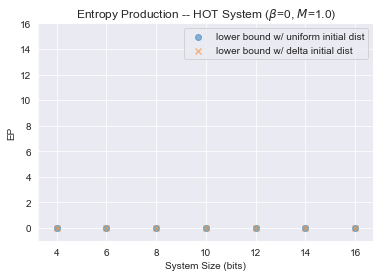

In [32]:
# ## To reload:
# with open('hot_lower_uniform.pickle', 'rb') as handle:
#     hot_lower_uniform_dict = pickle.load(handle)

plt.scatter(hot_lower_uniform_dict.keys(),hot_lower_uniform_dict.values(),alpha=0.5,label='lower bound w/ uniform initial dist')
plt.scatter(hot_lower_delta_dict.keys(),hot_lower_delta_dict.values(),marker='x',alpha=0.5,label='lower bound w/ delta initial dist')
plt.xlabel('System Size (bits)')
plt.ylabel('EP')
plt.title(r'Entropy Production -- HOT System ($\beta$='+str(0) +', $M$='+str(M)+')')
plt.ylim((-1,16))
plt.legend(loc='best')
# plt.savefig('EP_bound_scaling_hot.pdf')
plt.show()